In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

In [3]:
X.shape

(70000, 784)

In [4]:
y.unique()

['5', '0', '4', '1', '9', '2', '3', '6', '7', '8']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [6]:
# Division en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### SANS PCA

In [7]:
# Définir les hyperparamètres à explorer
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Créer un objet KNN
knn = KNeighborsClassifier()

# Effectuer une recherche de grille avec validation croisée
grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et la précision (accuracy) associée
print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Précision (accuracy) : ", grid_search.best_score_)

Meilleurs hyperparamètres :  {'n_neighbors': 3}
Précision (accuracy) :  0.9686530612244898


In [28]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto')

# Entraîner le modèle sur l'ensemble de formation
knn.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = knn.predict(X_test)

# Évaluer les performances du modèle en utilisant la précision (accuracy)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9717619047619047


In [19]:
param_grid = [    { 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]}
]

# Initialisation de la grille de recherche
log_reg = LogisticRegression(random_state=42)
grid_search_lg = GridSearchCV(log_reg, param_grid, cv=3, n_jobs=-1, verbose=2)

# Entraînement de la grille de recherche
grid_search_lg.fit(X_train, y_train)

# Meilleurs hyperparamètres et score sur l'ensemble de test
best_params = grid_search_lg.best_params_
print("Meilleurs hyperparamètres : ", best_params)
best_score = grid_search_lg.best_score_
print("Score sur l'ensemble d'apprentissage : ", best_score)
test_score = grid_search_lg.score(X_test, y_test)
print("Score sur l'ensemble de test : ", test_score)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Meilleurs hyperparamètres :  {'C': 1, 'penalty': 'l2'}
Score sur l'ensemble d'apprentissage :  0.9132244843093368
Score sur l'ensemble de test :  0.9196666666666666


### Maintenant on applique PCA 

On tracer la variance expliquée cumulative en fonction du nombre de composantes principales conservées après une réduction de dimensionnalité avec l'analyse en composantes principales (PCA). Cela permet de déterminer le nombre de composantes principales qui capturent la variance des données de manière satisfaisante.

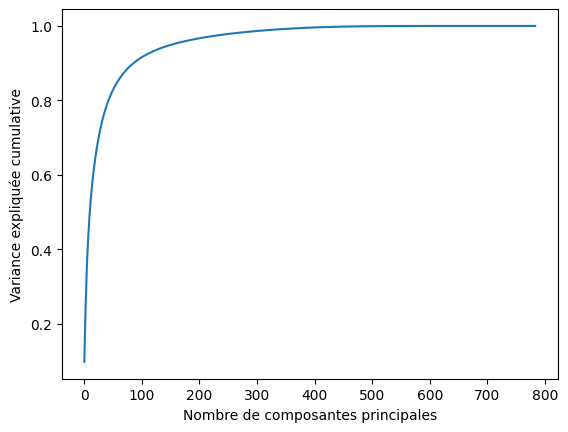

In [21]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulative')
plt.show()


le nombre optimal est ~ 75

In [34]:
# Réduction de la dimension en utilisant PCA
pca = PCA(n_components=75, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [35]:
# Entraînement du classifieur KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_train)
y_pred_knn = knn.predict(X_test_pca)
acc_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy KNN : ", acc_knn)

Accuracy KNN :  0.9559047619047619


In [39]:
log_reg = LogisticRegression(random_state=42, max_iter=1000, C=1 , penalty='l2')
log_reg.fit(X_train_pca, y_train)
y_pred_lr = log_reg.predict(X_test_pca)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy régression logistique : ", acc_lr)

Accuracy régression logistique :  0.9152857142857143


------------------

Il est possible que la réduction de dimension avec PCA ait enlevé des informations importantes pour la classification des images, ce qui a conduit à une diminution de la précision des modèles utilisés.

En effet, la réduction de dimension avec PCA permet de réduire la complexité des données et de faciliter l'entraînement des modèles, mais cela peut également entraîner une perte d'informations importantes pour la tâche de classification. De plus, la sélection du nombre de composantes principales à conserver peut avoir un impact important sur les performances des modèles, et il est possible que la valeur choisie n'ait pas été optimale dans ce cas précis.

Il est également possible que les modèles choisis (k-NN et régression logistique) ne soient pas les plus adaptés pour cette tâche, et que d'autres algorithmes plus complexes (par exemple, les réseaux de neurones convolutifs) puissent obtenir de meilleures performances sur ces données.

---------------------

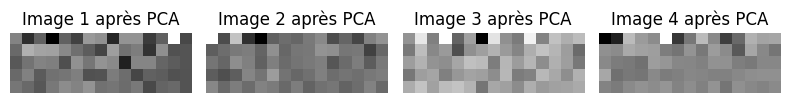

In [56]:
# Visualiser les images après la PCA
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 2))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_pca[i].reshape(5, 15), cmap='gray')
    ax.set_title("Image {} après PCA".format(i+1))
    ax.axis('off')

plt.tight_layout()
plt.show()


Lorsqu'on applique PCA sur les images, on peut perdre une partie des détails et des informations fines, ce qui peut rendre les images floues et moins nettes. Cela peut être une raison pour laquelle l'accuracy est plus basse après avoir appliqué PCA.

Cependant, il est important de noter que PCA présente également de nombreux avantages. En réduisant la dimensionnalité des données, PCA permet de mieux visualiser les données, de réduire le bruit et la redondance des données, et de rendre l'apprentissage plus rapide et moins complexe pour les modèles de machine learning. De plus, en réduisant la dimensionnalité, PCA peut aider à éviter le surapprentissage (overfitting) et améliorer la généralisation des modèles.